In [71]:
# from google.colab import drive
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.utils.model_zoo as model_zoo
import math
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from torch.utils.data.sampler import Sampler
import os
import random
import skimage.io
import skimage.transform
import skimage.color
import skimage
from torchvision import transforms
import torch.optim as optim
import collections
import json
from pycocotools.cocoeval import COCOeval
from IPython.display import Image

In [ ]:
drive.mount('/content/drive')

## Build the model

### Pre-trianed ResNet-50 or Resnet-101 as Backbone

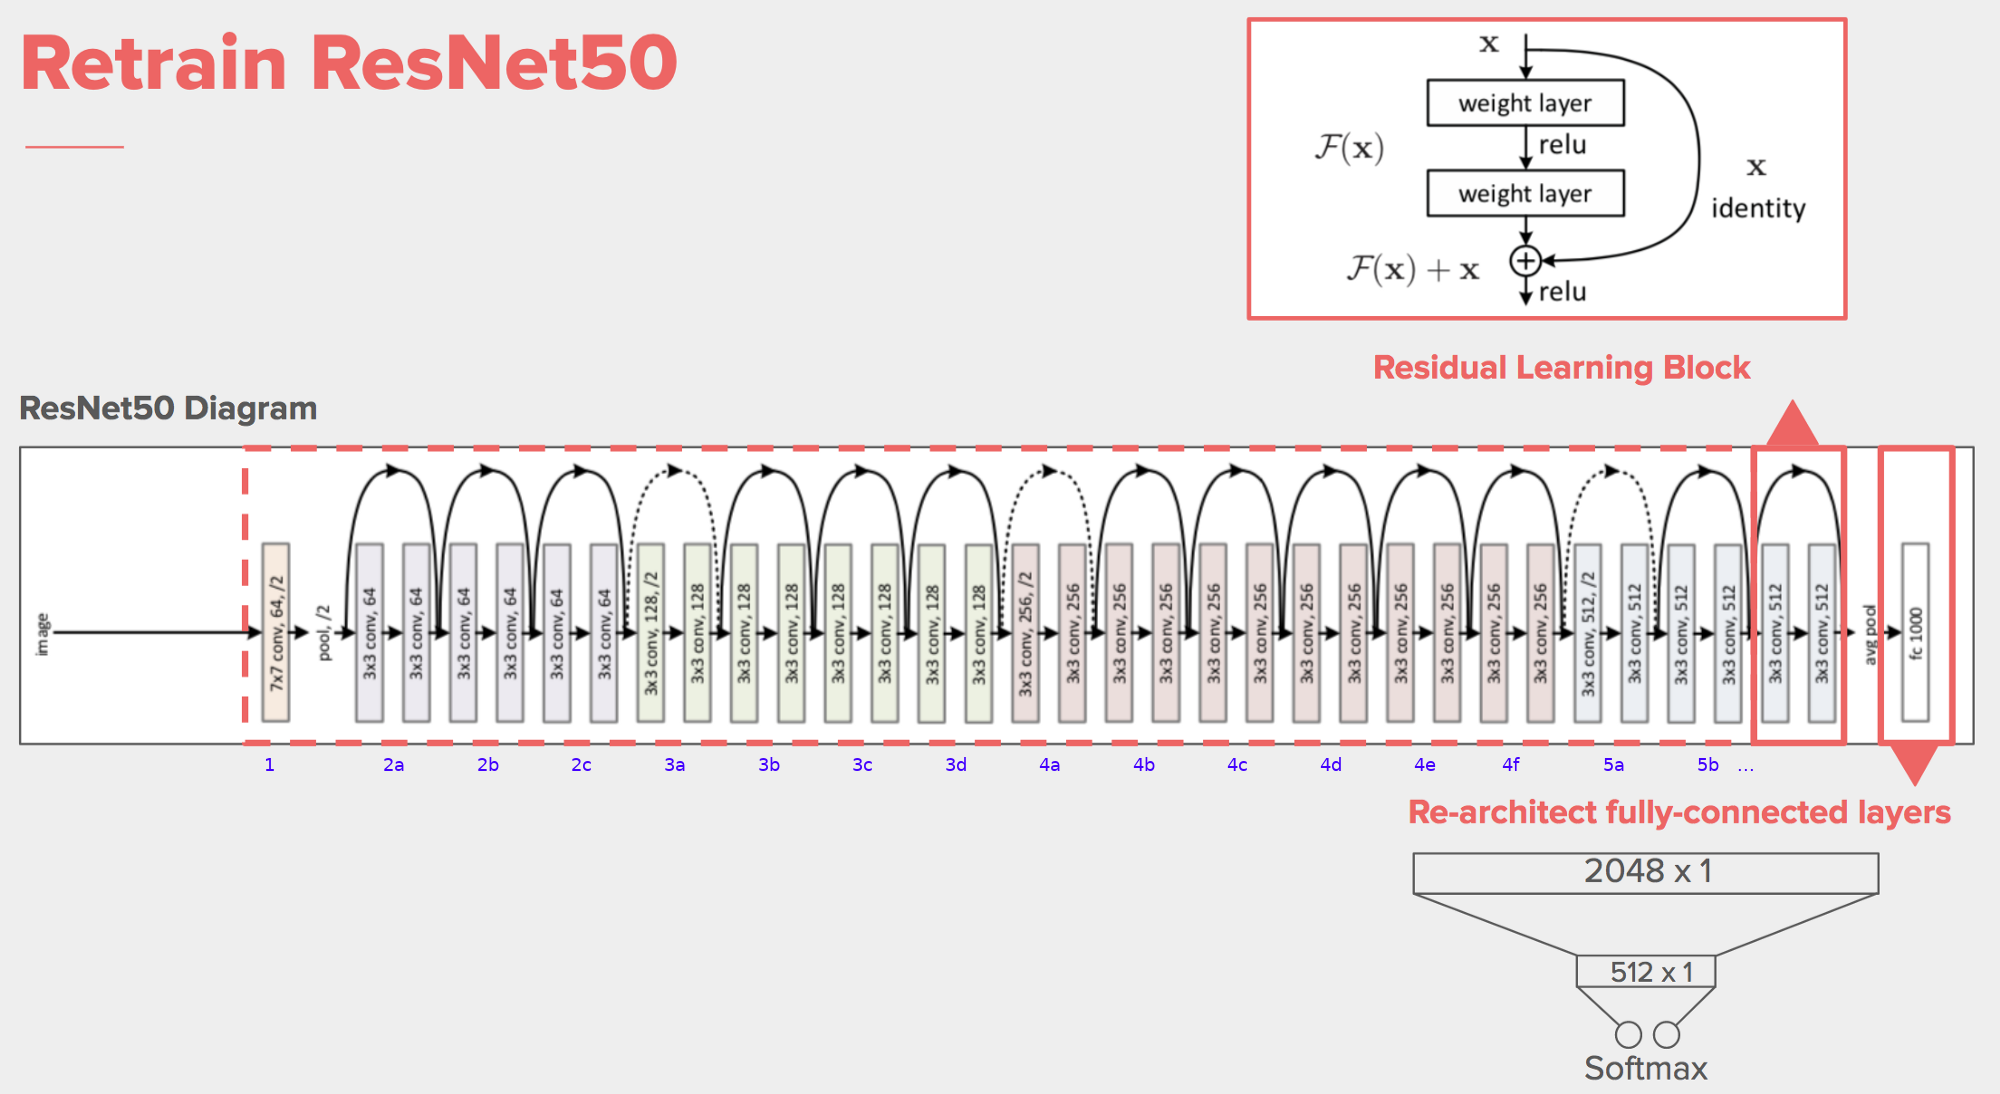

In [6]:
Image(filename='./images/ResNet50.png')

In [4]:
model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
}

### Feature Pyramid Network

- Undergoes 1×1 convolutions to reduce the channel dimensions.
- The feature maps from the bottom-up pathway and the top-down pathway are merged by element-wise addition.
- A 3×3 convolution is appended on each merged map to generate the final feature map, which is to reduce the aliasing effect of upsampling.

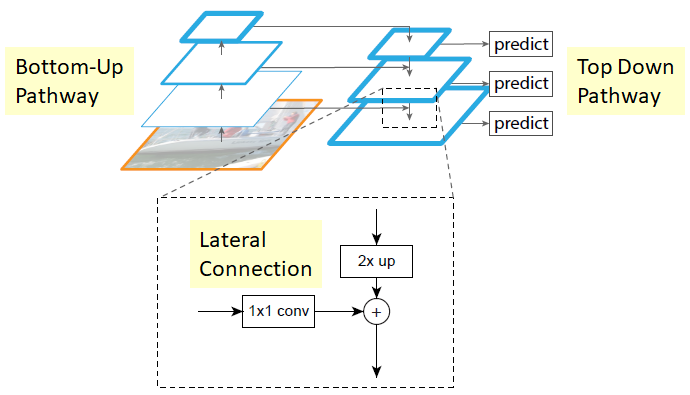

In [4]:
Image(filename='./images/FPN.png')

In [5]:
class PyramidFeatures(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super(PyramidFeatures, self).__init__()

        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # "P6 is obtained via a 3x3 stride-2 conv on C5"
        self.P6 = nn.Conv2d(C5_size, feature_size, kernel_size=3, stride=2, padding=1)

        # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
        self.P7_1 = nn.ReLU()
        self.P7_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        P3_x = self.P3_2(P3_x)

        P6_x = self.P6(C5)

        P7_x = self.P7_1(P6_x)
        P7_x = self.P7_2(P7_x)

        return [P3_x, P4_x, P5_x, P6_x, P7_x]

### Classification and Regression Subnet

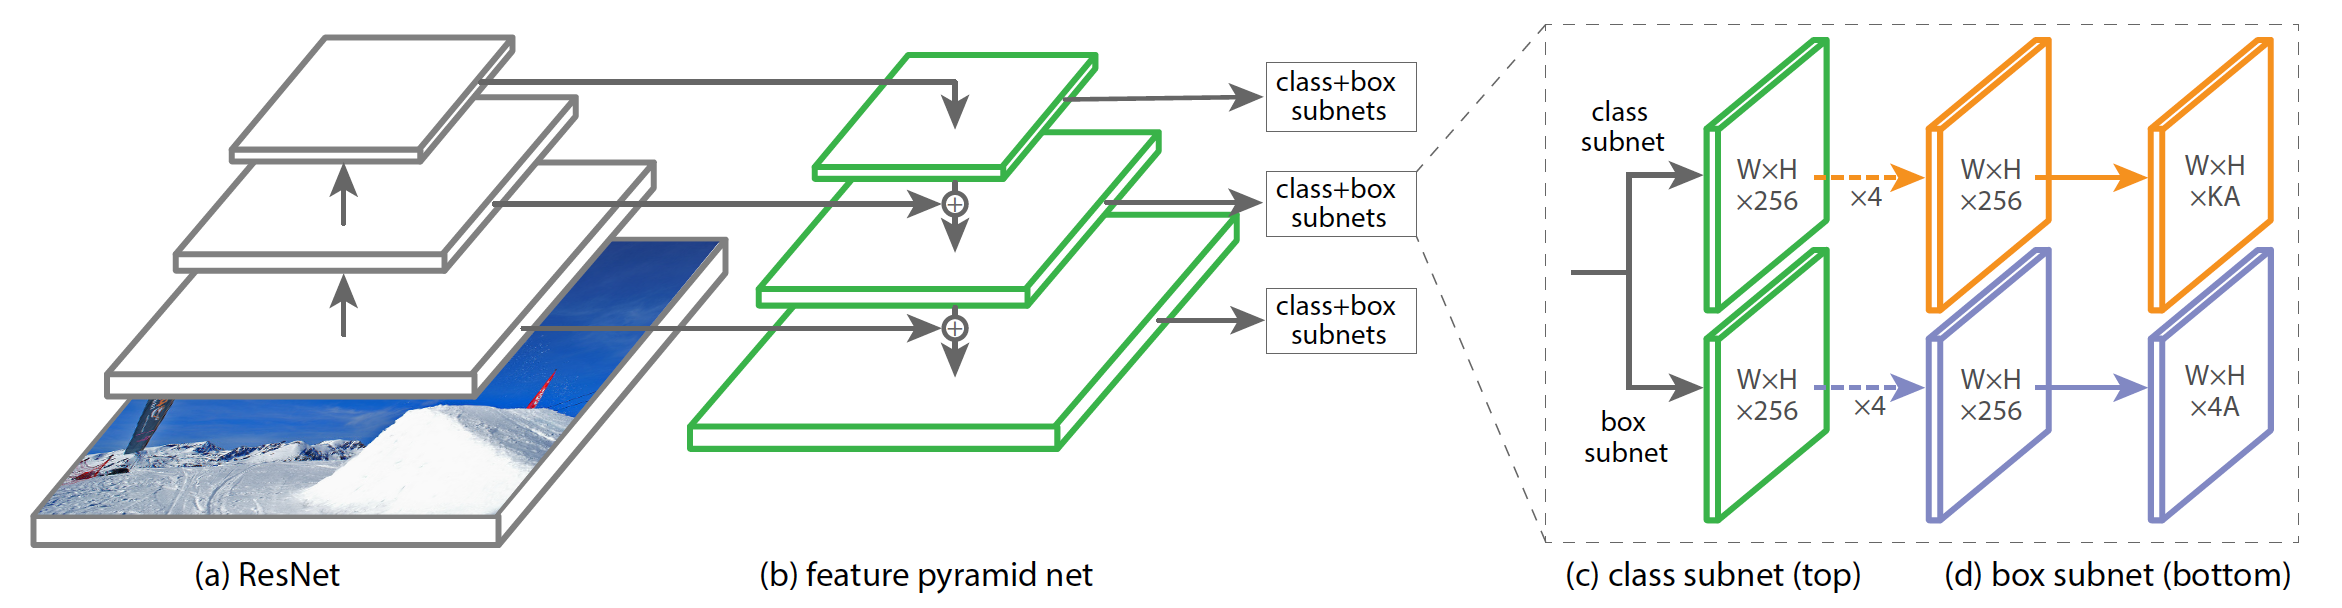

In [5]:
Image(filename='./images/Regression.png')

In [6]:
class ClassificationModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, num_classes=80, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()


class RegressionModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, feature_size=256):
        super(RegressionModel, self).__init__()

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * 4, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)

        # out is B x C x W x H, with C = 4*num_anchors
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 4)

### Generate Anchors

In [7]:
def generate_anchors(base_size=16, ratios=None, scales=None):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales w.r.t. a reference window.
    """
    if ratios is None:
        ratios = np.array([0.5, 1, 2])
    if scales is None:
        scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    num_anchors = len(ratios) * len(scales)
    # initialize output anchors
    anchors = np.zeros((num_anchors, 4))
    # scale base_size
    anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T
    # compute areas of anchors
    areas = anchors[:, 2] * anchors[:, 3]
    # correct for ratios
    anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
    anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))
    # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors

def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel(),
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors

class Anchors(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None):
        super(Anchors, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
        if ratios is None:
            self.ratios = np.array([0.5, 1, 2])
        if scales is None:
            self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])
    
    def forward(self, image):
        
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        # compute anchors over all pyramid levels
        all_anchors = np.zeros((0, 4)).astype(np.float32)

        for idx, p in enumerate(self.pyramid_levels):
            anchors         = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

        all_anchors = np.expand_dims(all_anchors, axis=0)

        if torch.cuda.is_available():
            return torch.from_numpy(all_anchors.astype(np.float32)).cuda()
        else:
            return torch.from_numpy(all_anchors.astype(np.float32))

### Bounding Box Transformation

In [8]:
class BBoxTransform(nn.Module):

    def __init__(self, mean=None, std=None):
        super(BBoxTransform, self).__init__()
        if mean is None:
            if torch.cuda.is_available():
                self.mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32)).cuda()
            else:
                self.mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32))

        else:
            self.mean = mean
        if std is None:
            if torch.cuda.is_available():
                self.std = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32)).cuda()
            else:
                self.std = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32))
        else:
            self.std = std

    def forward(self, boxes, deltas):

        widths  = boxes[:, :, 2] - boxes[:, :, 0]
        heights = boxes[:, :, 3] - boxes[:, :, 1]
        ctr_x   = boxes[:, :, 0] + 0.5 * widths
        ctr_y   = boxes[:, :, 1] + 0.5 * heights

        dx = deltas[:, :, 0] * self.std[0] + self.mean[0]
        dy = deltas[:, :, 1] * self.std[1] + self.mean[1]
        dw = deltas[:, :, 2] * self.std[2] + self.mean[2]
        dh = deltas[:, :, 3] * self.std[3] + self.mean[3]

        pred_ctr_x = ctr_x + dx * widths
        pred_ctr_y = ctr_y + dy * heights
        pred_w     = torch.exp(dw) * widths
        pred_h     = torch.exp(dh) * heights

        pred_boxes_x1 = pred_ctr_x - 0.5 * pred_w
        pred_boxes_y1 = pred_ctr_y - 0.5 * pred_h
        pred_boxes_x2 = pred_ctr_x + 0.5 * pred_w
        pred_boxes_y2 = pred_ctr_y + 0.5 * pred_h

        pred_boxes = torch.stack([pred_boxes_x1, pred_boxes_y1, pred_boxes_x2, pred_boxes_y2], dim=2)

        return pred_boxes

class ClipBoxes(nn.Module):

    def __init__(self, width=None, height=None):
        super(ClipBoxes, self).__init__()

    def forward(self, boxes, img):

        batch_size, num_channels, height, width = img.shape

        boxes[:, :, 0] = torch.clamp(boxes[:, :, 0], min=0)
        boxes[:, :, 1] = torch.clamp(boxes[:, :, 1], min=0)

        boxes[:, :, 2] = torch.clamp(boxes[:, :, 2], max=width)
        boxes[:, :, 3] = torch.clamp(boxes[:, :, 3], max=height)
      
        return boxes

### Focal Loss

\begin{equation}
FL(p_t) = -(1-p_t)^\gamma \log(p_t)
\end{equation}

where,
\begin{equation}
p_t = \begin{cases}
p & if \ y = 1 \\
1 - p & otherwise,
\end{cases} 
\end{equation}




In [9]:
def calc_iou(a, b):
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])

    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)

    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih

    ua = torch.clamp(ua, min=1e-8)

    intersection = iw * ih

    IoU = intersection / ua

    return IoU

class FocalLoss(nn.Module):
    def __init__(self):
        super(FocalLoss, self).__init__()
    
    def forward(self, classifications, regressions, anchors, annotations):
        alpha = 0.25
        gamma = 2.0
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []
        anchor = anchors[0, :, :]

        anchor_widths  = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_ctr_x   = anchor[:, 0] + 0.5 * anchor_widths
        anchor_ctr_y   = anchor[:, 1] + 0.5 * anchor_heights

        for j in range(batch_size):
            classification = classifications[j, :, :]
            regression = regressions[j, :, :]

            # GT box
            bbox_annotation = annotations[j, :, :]
            bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1]
            classification = torch.clamp(classification, 1e-4, 1.0 - 1e-4)

            # if no GT box in this batch
            if bbox_annotation.shape[0] == 0:
                if torch.cuda.is_available():
                    alpha_factor = torch.ones(classification.shape).cuda() * alpha
                else:
                    alpha_factor = torch.ones(classification.shape) * alpha
        
                alpha_factor = 1. - alpha_factor
                focal_weight = classification
                focal_weight = alpha_factor * torch.pow(focal_weight, gamma)
                bce = -(torch.log(1.0 - classification))
                # cls_loss = focal_weight * torch.pow(bce, gamma)
                cls_loss = focal_weight * bce
        
                classification_losses.append(cls_loss.sum())
                if torch.cuda.is_available():
                    regression_losses.append(torch.tensor(0).float().cuda())
                else:
                    regression_losses.append(torch.tensor(0).float())
                continue
      
            IoU = calc_iou(anchors[0, :, :], bbox_annotation[:, :4]) # num_anchors x num_annotations

            IoU_max, IoU_argmax = torch.max(IoU, dim=1) # num_anchors x 1x 1

            # compute the loss for classification
            targets = torch.ones(classification.shape) * -1

            if torch.cuda.is_available():
                targets = targets.cuda()

            targets[torch.lt(IoU_max, 0.4), :] = 0
            positive_indices = torch.ge(IoU_max, 0.5)
            num_positive_anchors = positive_indices.sum()
            assigned_annotations = bbox_annotation[IoU_argmax, :]
            targets[positive_indices, :] = 0
            targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

            if torch.cuda.is_available():
                alpha_factor = torch.ones(targets.shape).cuda() * alpha
            else:
                alpha_factor = torch.ones(targets.shape) * alpha

            alpha_factor = torch.where(torch.eq(targets, 1.), alpha_factor, 1. - alpha_factor)
            focal_weight = torch.where(torch.eq(targets, 1.), 1. - classification, classification)
            focal_weight = alpha_factor * torch.pow(focal_weight, gamma)
            bce = -(targets * torch.log(classification) + (1.0 - targets) * torch.log(1.0 - classification))
            # cls_loss = focal_weight * torch.pow(bce, gamma)
            cls_loss = focal_weight * bce

            if torch.cuda.is_available():
                cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape).cuda())
            else:
                cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape))

            classification_losses.append(cls_loss.sum()/torch.clamp(num_positive_anchors.float(), min=1.0))
      
            # compute the loss for regression

            if positive_indices.sum() > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths  = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_ctr_x   = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y   = assigned_annotations[:, 1] + 0.5 * gt_heights

                # clip widths to 1
                gt_widths  = torch.clamp(gt_widths, min=1)
                gt_heights = torch.clamp(gt_heights, min=1)

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
                targets = targets.t()

                if torch.cuda.is_available():
                    targets = targets/torch.Tensor([[0.1, 0.1, 0.2, 0.2]]).cuda()
                else:
                    targets = targets/torch.Tensor([[0.1, 0.1, 0.2, 0.2]])

                negative_indices = 1 + (~positive_indices)

                regression_diff = torch.abs(targets - regression[positive_indices, :])

                regression_loss = torch.where(
                    torch.le(regression_diff, 1.0 / 9.0),
                    0.5 * 9.0 * torch.pow(regression_diff, 2),
                    regression_diff - 0.5 / 9.0
                )
                regression_losses.append(regression_loss.mean())
            else:
                if torch.cuda.is_available():
                    regression_losses.append(torch.tensor(0).float().cuda())
                else:
                    regression_losses.append(torch.tensor(0).float())

        return torch.stack(classification_losses).mean(dim=0, keepdim=True), \
               torch.stack(regression_losses).mean(dim=0, keepdim=True)


### Combine all the above networks into Retinanet.

In [10]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, num_classes, block, layers):
        super(ResNet, self).__init__()
        self.inplanes = 64

        # conv1
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # conv2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        # conv3
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # conv4
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # conv5
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        fpn_sizes = [self.layer2[layers[1] - 1].conv3.out_channels, 
                     self.layer3[layers[2] - 1].conv3.out_channels, 
                     self.layer4[layers[3] - 1].conv3.out_channels]

        self.fpn = PyramidFeatures(fpn_sizes[0], fpn_sizes[1], fpn_sizes[2])
        self.regressionModel = RegressionModel(256)
        self.classificationModel = ClassificationModel(256, num_classes=num_classes)
        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()
        self.focalLoss = FocalLoss()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        prior = 0.01

        self.classificationModel.output.weight.data.fill_(0)
        self.classificationModel.output.bias.data.fill_(-math.log((1.0 - prior) / prior))
        self.regressionModel.output.weight.data.fill_(0)
        self.regressionModel.output.bias.data.fill_(0)
        self.freeze_bn()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def forward(self, inputs):

        if self.training:
            img_batch, annotations = inputs
        else:
            img_batch = inputs

        x = self.conv1(img_batch)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        features = self.fpn([x2, x3, x4])
        regression = torch.cat([self.regressionModel(feature) for feature in features], dim=1)
        classification = torch.cat([self.classificationModel(feature) for feature in features], dim=1)
        anchors = self.anchors(img_batch)

        if self.training:
            return self.focalLoss(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, img_batch)

            finalResult = [[], [], []]

            finalScores = torch.Tensor([])
            finalAnchorBoxesIndexes = torch.Tensor([]).long()
            finalAnchorBoxesCoordinates = torch.Tensor([])

            if torch.cuda.is_available():
                finalScores = finalScores.cuda()
                finalAnchorBoxesIndexes = finalAnchorBoxesIndexes.cuda()
                finalAnchorBoxesCoordinates = finalAnchorBoxesCoordinates.cuda()

            for i in range(classification.shape[2]):
                scores = torch.squeeze(classification[:, :, i])
                scores_over_thresh = (scores > 0.05)
                if scores_over_thresh.sum() == 0:
                    # no boxes to NMS, just continue
                    continue

                scores = scores[scores_over_thresh]
                anchorBoxes = torch.squeeze(transformed_anchors)
                anchorBoxes = anchorBoxes[scores_over_thresh]
                anchors_nms_idx = nms(anchorBoxes, scores, 0.5)

                finalResult[0].extend(scores[anchors_nms_idx])
                finalResult[1].extend(torch.tensor([i] * anchors_nms_idx.shape[0]))
                finalResult[2].extend(anchorBoxes[anchors_nms_idx])

                finalScores = torch.cat((finalScores, scores[anchors_nms_idx]))
                finalAnchorBoxesIndexesValue = torch.tensor([i] * anchors_nms_idx.shape[0])
                if torch.cuda.is_available():
                    finalAnchorBoxesIndexesValue = finalAnchorBoxesIndexesValue.cuda()

                finalAnchorBoxesIndexes = torch.cat((finalAnchorBoxesIndexes, finalAnchorBoxesIndexesValue))
                finalAnchorBoxesCoordinates = torch.cat((finalAnchorBoxesCoordinates, anchorBoxes[anchors_nms_idx]))

            return [finalScores, finalAnchorBoxesIndexes, finalAnchorBoxesCoordinates]

def resnet50(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50'], model_dir='.'), strict=False)
    return model

def resnet101(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101'], model_dir='.'), strict=False)
    return model


## Load dataset

In [11]:
class CocoDataset(Dataset):
    """Coco dataset."""

    def __init__(self, root_dir, set_name='train2017', transform=None):
        """
        Args:
            root_dir (string): COCO directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.set_name = set_name
        self.transform = transform

        self.coco      = COCO(os.path.join(self.root_dir, 'annotations', 'instances_' + self.set_name + '.json'))
        self.image_ids = self.coco.getImgIds()

        self.load_classes()

    def load_classes(self):
        # load class names (name -> label)
        categories = self.coco.loadCats(self.coco.getCatIds())
        categories.sort(key=lambda x: x['id'])

        self.classes             = {}
        self.coco_labels         = {}
        self.coco_labels_inverse = {}
        for c in categories:
            self.coco_labels[len(self.classes)] = c['id']
            self.coco_labels_inverse[c['id']] = len(self.classes)
            self.classes[c['name']] = len(self.classes)

        # also load the reverse (label -> name)
        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):

        img = self.load_image(idx)
        annot = self.load_annotations(idx)
        sample = {'img': img, 'annot': annot}
        if self.transform:
            sample = self.transform(sample)

        return sample

    def load_image(self, image_index):
        image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
        path       = os.path.join(self.root_dir, 'images', self.set_name, image_info['file_name'])
        img = skimage.io.imread(path)

        if len(img.shape) == 2:
            img = skimage.color.gray2rgb(img)

        return img.astype(np.float32)/255.0

    def load_annotations(self, image_index):
        # get ground truth annotations
        annotations_ids = self.coco.getAnnIds(imgIds=self.image_ids[image_index], iscrowd=False)
        annotations     = np.zeros((0, 5))

        # some images appear to miss annotations (like image with id 257034)
        if len(annotations_ids) == 0:
            return annotations

        # parse annotations
        coco_annotations = self.coco.loadAnns(annotations_ids)
        for idx, a in enumerate(coco_annotations):

            # some annotations have basically no width / height, skip them
            if a['bbox'][2] < 1 or a['bbox'][3] < 1:
                continue

            annotation        = np.zeros((1, 5))
            annotation[0, :4] = a['bbox']
            annotation[0, 4]  = self.coco_label_to_label(a['category_id'])
            annotations       = np.append(annotations, annotation, axis=0)

        # transform from [x, y, w, h] to [x1, y1, x2, y2]
        annotations[:, 2] = annotations[:, 0] + annotations[:, 2]
        annotations[:, 3] = annotations[:, 1] + annotations[:, 3]

        return annotations

    def coco_label_to_label(self, coco_label):
        return self.coco_labels_inverse[coco_label]


    def label_to_coco_label(self, label):
        return self.coco_labels[label]

    def image_aspect_ratio(self, image_index):
        image = self.coco.loadImgs(self.image_ids[image_index])[0]
        return float(image['width']) / float(image['height'])

    def num_classes(self):
        return 80

def collater(data):

    imgs = [s['img'] for s in data]
    annots = [s['annot'] for s in data]
    scales = [s['scale'] for s in data]
        
    widths = [int(s.shape[0]) for s in imgs]
    heights = [int(s.shape[1]) for s in imgs]
    batch_size = len(imgs)

    max_width = np.array(widths).max()
    max_height = np.array(heights).max()

    padded_imgs = torch.zeros(batch_size, max_width, max_height, 3)

    for i in range(batch_size):
        img = imgs[i]
        padded_imgs[i, :int(img.shape[0]), :int(img.shape[1]), :] = img

    max_num_annots = max(annot.shape[0] for annot in annots)
    
    if max_num_annots > 0:

        annot_padded = torch.ones((len(annots), max_num_annots, 5)) * -1

        if max_num_annots > 0:
            for idx, annot in enumerate(annots):
                #print(annot.shape)
                if annot.shape[0] > 0:
                    annot_padded[idx, :annot.shape[0], :] = annot
    else:
        annot_padded = torch.ones((len(annots), 1, 5)) * -1


    padded_imgs = padded_imgs.permute(0, 3, 1, 2)

    return {'img': padded_imgs, 'annot': annot_padded, 'scale': scales}

class Resizer(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, min_side=608, max_side=1024):
        image, annots = sample['img'], sample['annot']

        rows, cols, cns = image.shape

        smallest_side = min(rows, cols)

        # rescale the image so the smallest side is min_side
        scale = min_side / smallest_side

        # check if the largest side is now greater than max_side, which can happen
        # when images have a large aspect ratio
        largest_side = max(rows, cols)

        if largest_side * scale > max_side:
            scale = max_side / largest_side

        # resize the image with the computed scale
        image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
        rows, cols, cns = image.shape

        pad_w = 32 - rows%32
        pad_h = 32 - cols%32

        new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)

        annots[:, :4] *= scale

        return {'img': torch.from_numpy(new_image), 'annot': torch.from_numpy(annots), 'scale': scale}


class Augmenter(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, flip_x=0.5):

        if np.random.rand() < flip_x:
            image, annots = sample['img'], sample['annot']
            image = image[:, ::-1, :]

            rows, cols, channels = image.shape

            x1 = annots[:, 0].copy()
            x2 = annots[:, 2].copy()
            
            x_tmp = x1.copy()

            annots[:, 0] = cols - x2
            annots[:, 2] = cols - x_tmp

            sample = {'img': image, 'annot': annots}

        return sample


class Normalizer(object):

    def __init__(self):
        self.mean = np.array([[[0.485, 0.456, 0.406]]])
        self.std = np.array([[[0.229, 0.224, 0.225]]])

    def __call__(self, sample):

        image, annots = sample['img'], sample['annot']

        return {'img':((image.astype(np.float32)-self.mean)/self.std), 'annot': annots}

class UnNormalizer(object):
    def __init__(self, mean=None, std=None):
        if mean == None:
            self.mean = [0.485, 0.456, 0.406]
        else:
            self.mean = mean
        if std == None:
            self.std = [0.229, 0.224, 0.225]
        else:
            self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


class AspectRatioBasedSampler(Sampler):

    def __init__(self, data_source, batch_size, drop_last):
        self.data_source = data_source
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.groups = self.group_images()

    def __iter__(self):
        random.shuffle(self.groups)
        for group in self.groups:
            yield group

    def __len__(self):
        if self.drop_last:
            return len(self.data_source) // self.batch_size
        else:
            return (len(self.data_source) + self.batch_size - 1) // self.batch_size

    def group_images(self):
        # determine the order of the images
        order = list(range(len(self.data_source)))
        order.sort(key=lambda x: self.data_source.image_aspect_ratio(x))

        # divide into groups, one group = one batch
        return [[order[x % len(order)] for x in range(i, i + self.batch_size)] for i in range(0, len(order), self.batch_size)]


## Train the model

In [12]:
def evaluate_coco(dataset, model, threshold=0.05):
    
    model.eval()
    
    with torch.no_grad():

        # start collecting results
        results = []
        image_ids = []

        for index in range(len(dataset)):
            data = dataset[index]
            scale = data['scale']

            # run network
            if torch.cuda.is_available():
                scores, labels, boxes = model(data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0))
            else:
                scores, labels, boxes = model(data['img'].permute(2, 0, 1).float().unsqueeze(dim=0))
            scores = scores.cpu()
            labels = labels.cpu()
            boxes  = boxes.cpu()

            # correct boxes for image scale
            boxes /= scale

            if boxes.shape[0] > 0:
                # change to (x, y, w, h) (MS COCO standard)
                boxes[:, 2] -= boxes[:, 0]
                boxes[:, 3] -= boxes[:, 1]

                # compute predicted labels and scores
                #for box, score, label in zip(boxes[0], scores[0], labels[0]):
                for box_id in range(boxes.shape[0]):
                    score = float(scores[box_id])
                    label = int(labels[box_id])
                    box = boxes[box_id, :]

                    # scores are sorted, so we can break
                    if score < threshold:
                        break

                    # append detection for each positively labeled class
                    image_result = {
                        'image_id'    : dataset.image_ids[index],
                        'category_id' : dataset.label_to_coco_label(label),
                        'score'       : float(score),
                        'bbox'        : box.tolist(),
                    }

                    # append detection to results
                    results.append(image_result)

            # append image to list of processed images
            image_ids.append(dataset.image_ids[index])

            # print progress
            print('{}/{}'.format(index, len(dataset)), end='\r')

        if not len(results):
            return

        # write output
        json.dump(results, open('{}_bbox_results.json'.format(dataset.set_name), 'w'), indent=4)

        # load results in COCO evaluation tool
        coco_true = dataset.coco
        coco_pred = coco_true.loadRes('{}_bbox_results.json'.format(dataset.set_name))

        # run COCO evaluation
        coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
        coco_eval.params.imgIds = image_ids
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        model.train()

        return

In [ ]:
dataset = 'coco'
depth = 50
use_gpu = True
epochs = 100

root_path = os.getcwd()
coco_path = os.path.join(root_path, 'coco')
dataset_train = CocoDataset(coco_path, set_name='train2017',
                            transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
dataset_val = CocoDataset(coco_path, set_name='val2017',
                          transform=transforms.Compose([Normalizer(), Resizer()]))
sampler = AspectRatioBasedSampler(dataset_train, batch_size=2, drop_last=False)
dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)

sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)


if depth == 50:
    retinanet = resnet50(num_classes=dataset_train.num_classes(), pretrained=True)
elif depth == 101:
    retinanet = resnet101(num_classes=dataset_train.num_classes(), pretrained=True)
else:
    raise ValueError('Unsupported model depth, must be one of 50, 101')

if use_gpu:
    if torch.cuda.is_available():
        retinanet = retinanet.cuda()

if torch.cuda.is_available():
    retinanet = torch.nn.DataParallel(retinanet).cuda()
else:
    retinanet = torch.nn.DataParallel(retinanet)

retinanet.training = True
optimizer = optim.Adam(retinanet.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
loss_hist = collections.deque(maxlen=500)

retinanet.train()
retinanet.module.freeze_bn()

print('Num training images: {}'.format(len(dataset_train)))

for epoch_num in range(epochs):
    retinanet.train()
    retinanet.module.freeze_bn()

    epoch_loss = []

    for iter_num, data in enumerate(dataloader_train):
        try:
            optimizer.zero_grad()
            if torch.cuda.is_available():
                classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot']])
            else:
                classification_loss, regression_loss = retinanet([data['img'].float(), data['annot']])

            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = classification_loss + regression_loss

            if bool(loss == 0):
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)
            optimizer.step()
            loss_hist.append(float(loss))
            epoch_loss.append(float(loss))

            print(
                'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                    epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))

            del classification_loss
            del regression_loss
        except Exception as e:
            print(e)
            continue

    print('Evaluating dataset')
    evaluate_coco(dataset_val, retinanet)
    scheduler.step(np.mean(epoch_loss))
    torch.save(retinanet.module, '{}_retinanet_{}.pt'.format(dataset, epoch_num))

    retinanet.eval()
torch.save(retinanet, 'model_final.pt')

loading annotations into memory...
Done (t=15.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to ./resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Num training images: 118287














































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































KeyboardInterrupt: 